# Simple Example of using the Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by US Environmental Protection Agency

This can be used to model granular activated carbon (GAC) systems.

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

//Mathieu: self calculated b1 =  PFHpA    0.43565
dtype: float64
//Mathieu: self calculated b2 =  PFHpA    0.360309
dtype: float64


## Files

This example uses "Example_TCE.xlsx" as its input file. 

Sheet "Properties" has chemical properties of compounds you wish to model. You can have more compounds in your Properties sheet than the model needs, so it may be helpful to create a standard sheet for numerous projects. 

Sheet "Kdata" has K [(ug/g)(L/ug)^(1/n)] & 1/n (unitless) information. 'brk' stores the days to complete breakthrough. 'q' is solid phase concentration (ug/g). 'AveC' is the average concentration (ug/L). This information can be calculated by the model for fitting data, but this provides a mechanism for storing/inputing these values for some simulations. 

Sheet "data" has a data structure for ['type', 'time', 'concentration', 'compound']. Where type corresponds to where samples were taken (e.g., 'influent', 'effluent'). 'Time' is numeric and should the maximum value determines the lengh of simulations (The units of 'Time' are listed in the "columnSpecs" sheet). 'Concentration' units are also listed in "columnSpecs". 'Compounds' should match those in "Properties", and should provide information for both influent and effluent data. 

Sheet "columnSpecs" has column information. 

An example of reading in these sheets is shown below.



In [2]:
# =============================================================================
# Define the File to analyze
# can be in different folder, must be explicit for file location or can 
# use referential convention '../data/filename.xlsx' or 'C:/folders.../filename'
# =============================================================================
fn = 'Example_PFHpA_1.xlsx'

# =============================================================================
# READ IN Chemical Property Information
# may need to change location of file, depending on where it is stored locally
# properties are included in 'fn' from above, but can be separate file as well
# =============================================================================
chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

# =============================================================================
# Read in Input File
# Can change location of data_sheet= and column_sheet= to match file naming
# =============================================================================
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

# Example 1: Simple, no fouling

    chem_type = 'halogenated alkenes' #omitted, see Example 2 for how to use
    water_type = 'Organic Free'       #omitted, see Example 2 for how to use
    nr = radial collocation points
    nz = axial collocation points
    k_data = pandas dataframe containing K & 1/n data (ug/g)(L/ug)^(1/n) expected

In [ ]:
for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )
    
    print('EBCT: ', np.round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']]) 
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    # only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    ### plotting results 
    # units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example1.png', dpi=300)
    
    
    tab2 = 'model-'+comp
    ## Set up file to write output
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example1.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)



In [4]:
column.psdm_Ds

Trichloroethylene    3.229310e-09
dtype: float64

## Example 1a - Changing influent concentration programmatically  & Changing EBCT

In [4]:
raw_data2 = raw_data.copy()              # create a copy of the raw data dataframe 
column_info2 = column_info[carbons[0]].copy()   # makes copy to change flowrate
## change the concentration associated with the 'influent' column
raw_data2[column.influent] = 5000        # 5ppm, rather than 50 ppm in original file



Trichloroethylene
EBCT:  9.4  min
EBCT:  6.27  min


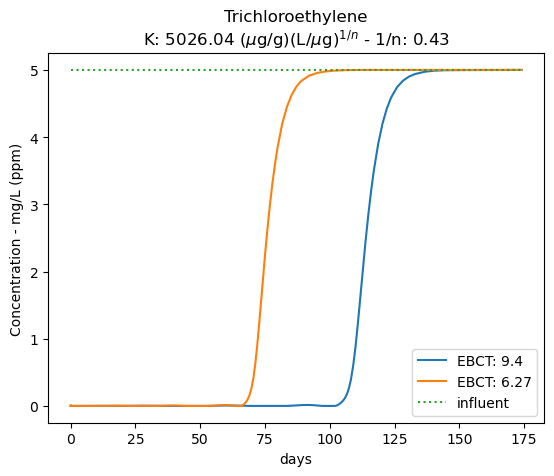

In [5]:
for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data2,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )
    
    print('EBCT: ', np.round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    # Change Flowrate, which changes EBCT, and rerun simulation
    column_info2['flrt'] = column_info[carbons[0]]['flrt'] * 1.5 # internal units are mL/min, this just multiplies by 1.5
    column2 = PSDM.PSDM(column_info2, 
                   chem_data, 
                   raw_data2,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )
    
    print('EBCT: ', np.round(column2.ebct, 2), ' min') 
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)

    
    ### Plotting results 
    # plot results for 1st EBCT
    plt.plot(results.index, 
             results.values/1000., 
             label='EBCT: '+repr(np.round(column.ebct,2)))
    # plot results for 2nd EBCT
    plt.plot(results2.index, 
             results2.values/1000., 
             label='EBCT: '+repr(np.round(column2.ebct,2)))
    (raw_data2[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example1a.png', dpi=300)
    
    tab2 = 'model-'+comp
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example1a.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)
    



# Example 2 - Variable influent

Variable influent data stored in "data_variable" sheet. Must reload info.
k_data didn't change, so will be reused from Example 1


In [3]:
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )
## User can look at raw_data to see new variable influent, or 
## see "data_variable" sheet


PFHpA
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  PFHpA    1.0
dtype: float64
rk2:  PFHpA    0.0
dtype: float64
rk3:  PFHpA    0.0
dtype: float64
rk4:  PFHpA    0.0
dtype: float64
//Mathieu: k_mult_pd:  [1. 1. 1. 1. 1.]  ...
EBCT:  9.88  min
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  PFHpA    0.512787
dtype: float64
rk2:  PFHpA   -2.679248e-08
dtype: float64
rk3:  PFHpA    0.283173
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd:  [0.79595906 0.73885526 0.69320457 0.65670365 0.62751237]  ...


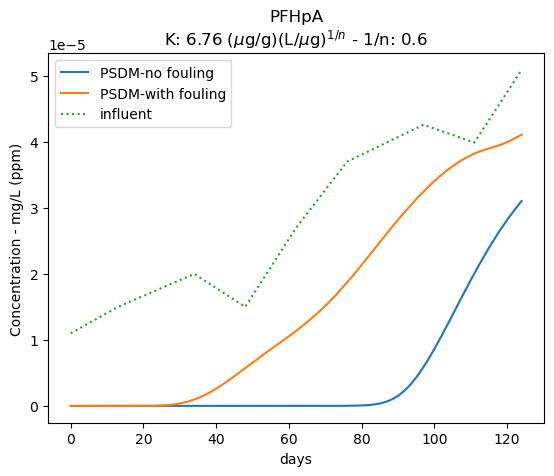

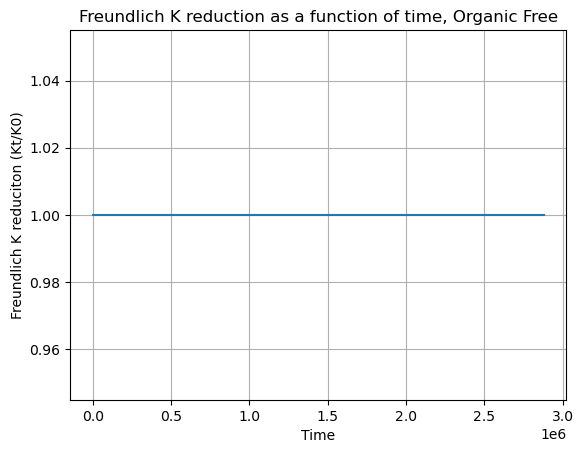

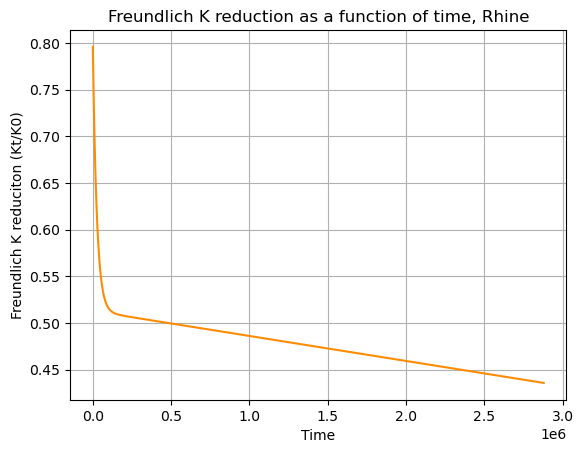

In [4]:
chem_type = 'PFAS'   #//Mathieu: according to article
water_type = 'Rhine' #//Mathieu: according to article
#note additional inputs in definition of column, below.

for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    print('EBCT: ', round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,
                   water_type=water_type,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-no fouling')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-with fouling')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column.K_time, column.K_new_time)
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.title('Freundlich K reduction as a function of time, Organic Free')  # Title of the plot
    plt.grid(True)  # Enable grid
    plt.show()  # Display the plot    
    
    plt.figure()
    plt.plot(column2.K_time, column2.K_new_time,color='darkorange')
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.title('Freundlich K reduction as a function of time, Rhine')  # Title of the plot
    plt.grid(True)  # Enable grid
    plt.show()  # Display the plot    
    
    tab2 = 'model-'+comp
    
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example2.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)



In [6]:
len(column.K_new_time)

500

In [7]:
len(column.K_time)

500

In [8]:
column.psdm_teller, column2.psdm_teller

(1, 1)

In [9]:
column.water_type, column2.water_type

('Organic Free', 'Rhine')

# Advanced Example

Demonstrating Fitting Capabilities.

Reloading all information for clarity.

Using "data_optimize" sheet, which contains time series of effluent breakthrough.

In [3]:
#reset files, just in case
chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data


raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data_optimize',\
                                               column_sheet='columnSpecs'
                                              )
## note data_sheet is now 'data_optimize'

chem_type = 'PFAS'
water_type = 'Rhine'

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  PFHpA    0.512787
dtype: float64
rk2:  PFHpA   -2.679248e-08
dtype: float64
rk3:  PFHpA    0.283173
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd =  [0.79595906 0.73885526 0.69320457 0.65670365 0.62751237 0.60416069
 0.58547419 0.57051466 0.55853256 0.5489291  0.5412259  0.5350408
 0.5300685  0.52606508 0.5228357  0.52022468 0.51810767 0.51638532
 0.51497825 0.51382306 0.51286909 0.51207588 0.51141109 0.5108489
 0.51036868 0.50995393 0.5095915  0.50927086 0.5089836  0.50872301
 0.50848374 0.50826148 0.50805283 0.50785504 0.50766592 0.50748375
 0.50730711 0.5071349  0.50696622 0.50680036 0.50663677 0.50647497
 0.50631462 0.50615542 0.50599713 0.50583958 0.50568262 0.50552612
 0.50537    0.50521418 0.50505859 0.5049032  0.50474796 0.50459284
 0.50443782 0.50428288 0.504128   0.50397317 0.503818

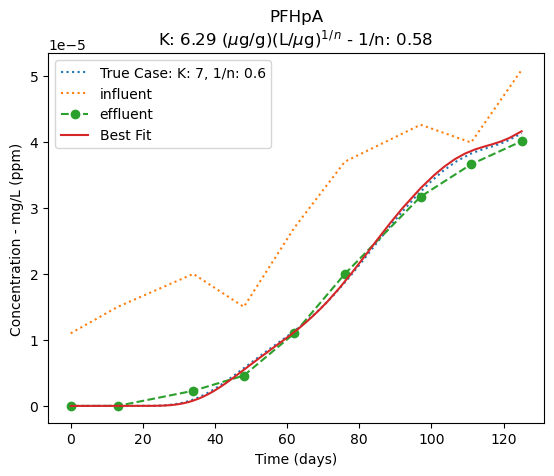

In [4]:
## This step can take a few minutes
for comp in compounds:
    print(comp)
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   #k_data=k_data,
                   chem_type=chem_type,
                   water_type=water_type,
                   optimize=False
                   )
    
    print(column.k_data)

    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    # only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    # print(results['data'][np.linspace(0,175,36)])
    
    plt.plot(results.index, 
             results.values/1000,':',
             label=f'True Case: K: {k_data[comp]["K"]:,.0f}, 1/n: {k_data[comp]["1/n"]}'
             )
    plt.plot(raw_data.index,
             raw_data[column_info[carbons[0]]['influentID']][comp].values/1000,
             label='influent',ls=':')
    plt.plot(raw_data.index,
             raw_data[carbons[0]][comp].values/1000.,
             label='effluent', marker='o',ls='--')
    
    
    column.xn_range = np.linspace(.3,.75,19) # increment 0.025
    # checks +/- 30% of estimated K (pm=30), 
    # and scans 1/n space in 0.01 step sizes (des_xn=0.01)
    column.run_all_smart(pm=30, des_xn=0.01)
    
    #Best fit was saved back to column.k_data
    print(column.k_data)
    
    _compound, k, xn, _ssqs, results2 = column.run_psdm_kfit(comp)
    
    plt.plot(results2.index,
             results2.values/1000.,
             label='Best Fit')
    
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(f'{comp}\nK: {k:,.2f} ($\mu$g/g)(L/$\mu$g)$^1$$^/$$^n$ - 1/n: {xn:.3}')
    plt.xlabel(f'Time ({column_info.loc["time"].values[0]})')
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example3.png', dpi=300)


In [5]:
column.psdm_teller

23

In [6]:
column.psdm_Ds

PFHpA    5.421448e-20
dtype: float64

In [7]:
column.mass_transfer

,PFHpA
kf,0.0
dp,0.0
ds,0.0


In [8]:
chem_data

,PFHpA
MW,364.060
MolarVol,203.158
BP,175.000
Density,1.792
Solubility,0.000
VaporPress,0.000
logKow,1.300
κ2,5.520
Nam,0.000
α,13.830


In [9]:
chem_data.loc['α']

PFHpA    13.83
Name: α, dtype: float64

# ALTERNATE OPTIMIZER
Depending on selections this can take 1+ hours per compound !!!!

Instead of:

column.xn_range = np.linspace(.3,.75,19) # increments by 0.025

column.run_all_smart(pm=30, des_xn=0.01)
            
            checks +/- 30% of estimated K (pm=30), 
            and scans 1/n space in 0.01 step sizes (des_xn=0.01)

in previous snippet.

Use:

column.xn_range = np.linspace(0.3, 0.75, 46) 

            46 = interval 0.01 (19 is 0.025, for 0.3-0.75)
            
column.test_range = np.linspace(1, 5, 41)

            41 gives you 0.1 increment on K_multiplier
            K would not be expected to be lower than 1, but upper 
            bound of 3 to 4 may be sufficient to capture any real 
            values
    
Then include:

column.run_all()
        
        or

column.run_all(optimize='brute') #run only this line or the line above, not both

best fits are again stored back to 'column.k_data'

    
run_all() by default uses a multi-staged brute force approach. This subdivides the space into coarse grids, and performs a series of refining steps. 

'optimizer=brute' searches every combination of xn_range and test_range, while the default 'staged' behavior attempts to quickly locate the minimum by taking a coarser search while seeking the minimum. 
    
including 'optimize=brute' could be used after run_all_smart() or the staged approach to ensure that the K & 1/n values around a minimum were thoroughly searched.
    
## Performance: 
                brute (1+ hours per compound)
                staged (~5-10+ minutes per compound, depending on complexity)
                using run_all_smart (~2-15 minutes per compound)
  


# Final Notes: 
If you got this far, you may be interested in using this for 
larger datasets. In the above examples, each of the examples is set up
for looped execution. If you provide datasets with more than one compound
in the data sheet (and associated properties) then this will loop over each
compound individually.
